# SIR MODEL

## NDL
**Network Diffusion Library** https://ndlib.readthedocs.io/en/latest/reference/reference.html

In the code below is shown an example of instantiation and execution of an SIR simulation on a random graph: we set the initial set of infected nodes as 5% of the overall population, a probability of infection of 1%, and a removal probability of 0.5%.


In [2]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

import utils.data_loader as loader

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import utils.link_addition_torch as lkadd
from tqdm import tqdm
def add_links(GW, N_LINKS, MODEL):
    for i in tqdm(range(N_LINKS)):
        #* Get score
        if MODEL == 'random':
            u, v = lkadd.get_random_link(GW.edge_mask)
        elif MODEL == 'ERP':
            S = GW.get_effective_resistance()
        else:
            opt_args = {'dim': 128, 'walk_length': 40, 'window_size': 10, 'workers': 4} if MODEL == 'deepwalk' else  {}
            S = lkadd.get_edge_score(GW, MODEL, **opt_args)

        #* Select edge based on score
        if MODEL != 'random':
            if MODEL == 'ERP':
                u,v = lkadd.get_weakest_link(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
            else:
                u,v = lkadd.get_strongest_link(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
        
        if GW.is_edge(u,v):
            raise Exception('Edge already exists')
        else:
            GW.add_link(u,v)
    return GW

def SIR(G, beta=0.005, lambda_sir=0.00, fraction_infected=0.005, iterations=200):

    # Model selection
    #model = ep.SIRModel(G)
    model = ep.SISModel(G)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    #cfg.add_model_parameter('gamma', 0.00)
    cfg.add_model_parameter('lambda', lambda_sir)
    cfg.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(cfg)

    # Simulation execution
    history = model.iteration_bunch(iterations)
    return history

In [4]:
DATASET = 'facebook'
DEVICE = 'cpu'
GW = loader.load_data(DATASET, device=DEVICE)
GW.num_edges, GW.num_nodes

Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact


(26749, 1034)

In [5]:
import copy
GW_erp = add_links(copy.copy(GW), 50, 'ERP')
GW_cos = add_links(copy.copy(GW), 50, 'cosine')
GW_rand = add_links(copy.copy(GW), 50, 'random')

100%|██████████| 50/50 [00:00<00:00, 64.31it/s]


GW_dw = add_links(GW, 100, 'deepwalk')

In [6]:
#from edgelist to networkx
G = nx.Graph()
G.add_edges_from(GW.edgelist.T.numpy())

G_erp = nx.Graph()
G_erp.add_edges_from(GW_erp.edgelist.T.numpy())

G_cos = nx.Graph()
G_cos.add_edges_from(GW_cos.edgelist.T.numpy())

G_rand = nx.Graph()
G_rand.add_edges_from(GW_rand.edgelist.T.numpy())

"""G_dw = nx.Graph()
G_dw.add_edges_from(GW_dw.edgelist.T.numpy())"""

G.number_of_edges(), G_erp.number_of_edges(), G_cos.number_of_edges(), G_rand.number_of_edges()

(26749, 26799, 26799, 26799)

In [7]:
import numpy as np

BETA = 1

iterations_G = []
iterations_G_erp = []
iterations_G_cos = []
iterations_G_rand = []

for _ in range(20):
    iter_G=SIR(G, beta=BETA)
    iter_G_erp=SIR(G_erp, beta=BETA)
    iter_G_cos=SIR(G_cos, beta=BETA)
    iter_G_rand=SIR(G_rand, beta=BETA)

    iterations_G.append([iteration['node_count'][1] for iteration in iter_G])
    iterations_G_erp.append([iteration['node_count'][1] for iteration in iter_G_erp])
    iterations_G_cos.append([iteration['node_count'][1] for iteration in iter_G_cos])
    iterations_G_rand.append([iteration['node_count'][1] for iteration in iter_G_rand])

iterations_G = np.array(iterations_G)
iterations_G_erp = np.array(iterations_G_erp)
iterations_G_cos = np.array(iterations_G_cos)
iterations_G_rand = np.array(iterations_G_rand)

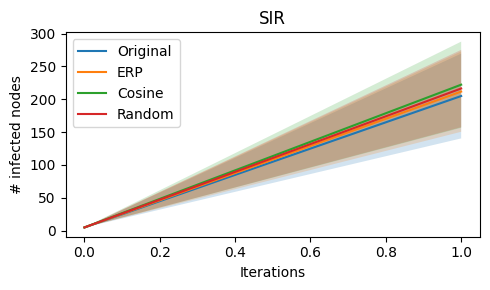

In [8]:
SIR_ITER =2


fig, ax = plt.subplots(1, figsize=(5, 3))
#show mean and std of each trend
mean_G = iterations_G.mean(axis=0)[:SIR_ITER]
std_G = iterations_G.std(axis=0)[:SIR_ITER]
ax.plot(mean_G, label='Original')
ax.fill_between(range(SIR_ITER), mean_G-std_G, mean_G+std_G, alpha=0.2)

mean_G_erp = iterations_G_erp.mean(axis=0)[:SIR_ITER]
std_G_erp = iterations_G_erp.std(axis=0)[:SIR_ITER]
ax.plot(mean_G_erp, label='ERP')
ax.fill_between(range(SIR_ITER), mean_G_erp-std_G_erp, mean_G_erp+std_G_erp, alpha=0.2)

mean_G_cos = iterations_G_cos.mean(axis=0)[:SIR_ITER]
std_G_cos = iterations_G_cos.std(axis=0)[:SIR_ITER]
ax.plot(mean_G_cos, label='Cosine')
ax.fill_between(range(SIR_ITER), mean_G_cos-std_G_cos, mean_G_cos+std_G_cos, alpha=0.2)

mean_G_rand = iterations_G_rand.mean(axis=0)[:SIR_ITER]
std_G_rand = iterations_G_rand.std(axis=0)[:SIR_ITER]
ax.plot(mean_G_rand, label='Random')
ax.fill_between(range(SIR_ITER), mean_G_rand-std_G_rand, mean_G_rand+std_G_rand, alpha=0.2)



ax.set_title('SIR')

ax.set_xlabel('Iterations')
ax.set_ylabel('# infected nodes')
ax.legend()
plt.tight_layout()
plt.show()

# Visualize random geometric graph

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
# Network topology
g = nx.random_geometric_graph(500, 0.1, seed=896803) # Random Clustered graph 1000 nodes - distance =0.05, no self loops

pos = nx.get_node_attributes(g, "pos")

In [11]:
# get the central node (central regarding the distance to 0.5, 0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(g, ncenter))

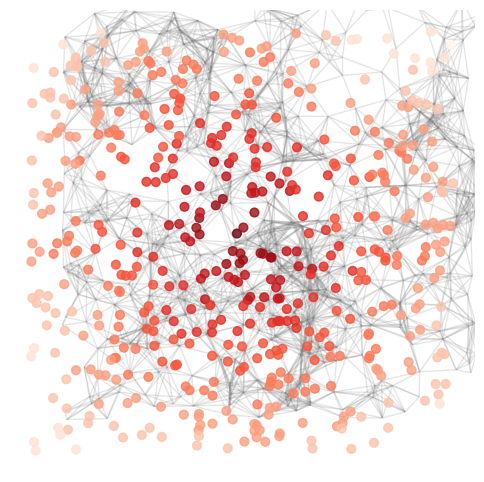

In [12]:
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(g, pos, alpha=0.2, edge_color="grey")
nx.draw_networkx_nodes(
    g,
    pos,
    nodelist=list(p.keys()),
    node_size=40,
    node_color=list(p.values()),
    cmap=plt.cm.Reds_r,
    alpha=0.8
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()